In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all words
words = open('../../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [33]:
block_size = 4
X,Y = [], []

for w in words:
    context = [0] * block_size
    
    for ch in w + '.':
        index = stoi[ch]
        X.append(context)
        Y.append(index)
        context = context[1:] + [index]

X  = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [15]:
X.dtype, Y.dtype

(torch.int64, torch.int64)

In [16]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g) 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters)

3481

In [18]:
for p in parameters:
    p.requires_grad = True

In [19]:
for _ in range(10):
    # forward pass
    embedding = C[X] # [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

44.72150421142578
31.339282989501953
26.639673233032227
22.7624568939209
19.259723663330078
17.22623634338379
15.650609970092773
14.105106353759766
12.778504371643066
12.003918647766113


We are taking a lot of time forwarding and backwarding 228146 examples and this cause a lot of delay in each iteration.

So to avoid this we need to take up mini batches and forward and backward those and then iterate such batches.

In [20]:
torch.randint(0,X.shape[0],(32,)) # tuple of 32 values between 0 and X's row length = 228146
# get the integers that index into the dataset and there are 32 of them

tensor([ 51298,  57578,  18834, 222278, 164665,  67943,  81447,  71501, 170398,
        114594,   9288,  85370, 200755,  13139, 200169,  73321,  93506,   6990,
        218103, 177651, 197447,  40244, 215781, 106743, 164795,  99997, 216448,
        219004, 216822, 146926,  51713, 187082])

#### Training the total dataset via mini batches

In [21]:
for _ in range(1000):
    
    # minibatch construct
    index = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    embedding = C[X[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Y[index]) # each minibatch for each Y
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

10.781827926635742
10.78913688659668
9.906920433044434
7.833869934082031
6.895164489746094
10.24615478515625
9.02752685546875
8.650331497192383
8.62949275970459
4.592645645141602
6.081714153289795
5.915469169616699
5.08931303024292
9.230311393737793
5.2963337898254395
6.154781341552734
6.462083339691162
6.759435653686523
5.56968879699707
6.7252397537231445
7.4239583015441895
5.986137390136719
6.856315612792969
5.537353515625
5.21685266494751
4.812972545623779
5.275628089904785
5.326972007751465
5.059751510620117
4.905519485473633
5.324665546417236
4.607382774353027
5.380007266998291
4.457831859588623
5.196204662322998
5.892793655395508
6.430344104766846
4.796012878417969
4.3694257736206055
5.01301908493042
5.041110992431641
3.9145026206970215
3.831570863723755
5.493465423583984
4.6449127197265625
6.244284152984619
7.017966270446777
6.426338195800781
5.1731648445129395
4.005890369415283
4.181943416595459
4.568422317504883
4.880014896392822
3.6120657920837402
3.7799439430236816
5.3265380

In this way we are able to run lots of such examples and therefore reduce the loss much much faster. But since we are taking minibatches, direction of the gradient is not linear and hence not relaiable and its not the actual the direct gradient. It is better therefore to have a approximate gradient and make more steps than finding a exact gradient and take less steps. Therefore this works best in practice.

In [22]:
print(loss.item()) # loss for the last minibatch trained

2.6650428771972656


In [23]:
# To get an idea about the loss of the entire dataset

embedding = C[X] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Y) # each minibatch for each Y
loss


tensor(2.8484, grad_fn=<NllLossBackward0>)

But one thing to note is we do not whats the correct speed to which we need to learn this. -0.1 is a value randomly taken. We need to therefore determine a reasonable learning rate

while -0.1 is kinda optimum value with -0.0001, -0.001 and -10, 1 really extreme.

So we can say a correct learning rate is somewhere between -0.001 and 1

In [24]:
torch.linspace(0.001, 1, 1000) # 1000 values between 0.001 and 1

tensor([0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090,
        0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180,
        0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260, 0.0270,
        0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350, 0.0360,
        0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450,
        0.0460, 0.0470, 0.0480, 0.0490, 0.0500, 0.0510, 0.0520, 0.0530, 0.0540,
        0.0550, 0.0560, 0.0570, 0.0580, 0.0590, 0.0600, 0.0610, 0.0620, 0.0630,
        0.0640, 0.0650, 0.0660, 0.0670, 0.0680, 0.0690, 0.0700, 0.0710, 0.0720,
        0.0730, 0.0740, 0.0750, 0.0760, 0.0770, 0.0780, 0.0790, 0.0800, 0.0810,
        0.0820, 0.0830, 0.0840, 0.0850, 0.0860, 0.0870, 0.0880, 0.0890, 0.0900,
        0.0910, 0.0920, 0.0930, 0.0940, 0.0950, 0.0960, 0.0970, 0.0980, 0.0990,
        0.1000, 0.1010, 0.1020, 0.1030, 0.1040, 0.1050, 0.1060, 0.1070, 0.1080,
        0.1090, 0.1100, 0.1110, 0.1120, 

#### Training the total dataset via mini batches and taking a reasonable learning rate

In [25]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

# -3 and 0 is because we need to correctly spaced between these examples.
# Since we assume it as exponents, 10**-3 = 0.001 and 10**0 = 1
lrs # stepping linearly between these exponents

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [35]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct
    index = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    embedding = C[X[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Y[index]) # each minibatch for each Y
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = lrs[i] # extracting learning rate from the array
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())

3.3875927925109863
2.6725568771362305
3.0699477195739746
2.928053140640259
3.0049540996551514
2.7653231620788574
3.09061861038208
3.319080114364624
3.3571293354034424
3.030670166015625
3.0442380905151367
2.7007977962493896
3.1492953300476074
3.4119598865509033
2.7934346199035645
3.0000691413879395
3.2437219619750977
2.97953462600708
2.8871042728424072
3.645336151123047
3.398355484008789
2.6361043453216553
2.7361888885498047
3.145482063293457
3.1098811626434326
2.6400508880615234
2.813462018966675
2.980459213256836
2.8964788913726807
3.116802930831909
2.9954090118408203
2.746152639389038
2.603903293609619
2.6236653327941895
2.69301438331604
3.213214635848999
3.0394132137298584
3.1894164085388184
3.113253355026245
2.888819932937622
2.4965600967407227
3.064652919769287
2.6141998767852783
2.8917112350463867
2.8066608905792236
2.4712073802948
2.7227847576141357
2.8789255619049072
2.477663278579712
3.3932487964630127
3.143810510635376
3.056333541870117
3.061318874359131
3.087738037109375
2.8

Much faster utilising learning rate starting off at -0.001 nd then -1

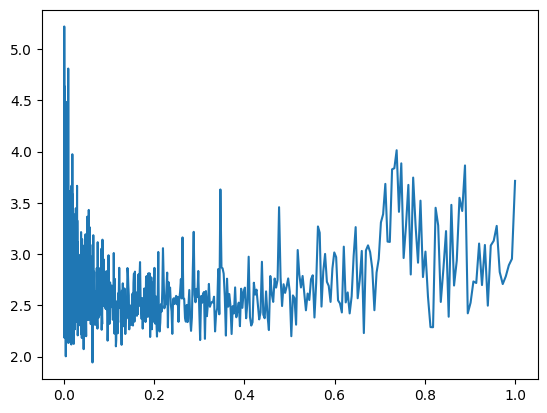

In [33]:
plt.plot(lri, lossi)

 On observing the graph, we see a good spot of minimal loss around 0.0 to 0.2 and then on again increasing the learning rate, a lot of uncertainity happened ( arround 0.6 to 0.8). And if we append lre[i] to lri and then plot we will see a valley towards the end. We expect really low learning rate somewhere around -0.1 as exponent of learning rate, everything is in good shape. Now we can surely say -0.1 is the one perfect learning rate.

In [39]:
lri = []
lossi = []

for i in range(10000):
    
    # minibatch construct
    index = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    embedding = C[X[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Y[index]) # each minibatch for each Y
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())

2.5976343154907227
2.344573497772217
2.3705785274505615
2.5482358932495117
2.3440353870391846
2.6519627571105957
2.527529716491699
2.6253952980041504
2.465625047683716
2.6302812099456787
2.4842283725738525
2.5490739345550537
2.650026559829712
2.7901389598846436
2.739600658416748
2.727004289627075
2.510399580001831
2.820643901824951
2.5945608615875244
2.3489878177642822
2.497885227203369
2.359527587890625
2.570862054824829
2.366748809814453
2.4484198093414307
2.4095089435577393
2.5982673168182373
2.4040093421936035
2.278115749359131
2.59297513961792
2.3399453163146973
2.3363945484161377
2.4234187602996826
2.751234769821167
2.6911699771881104
2.092057228088379
2.8796637058258057
2.4764389991760254
2.410737991333008
2.423288583755493
2.8474748134613037
2.4716339111328125
2.512460470199585
2.8489062786102295
2.6307694911956787
2.4747440814971924
2.657827854156494
2.618730306625366
2.7098238468170166
2.569591760635376
2.4350852966308594
2.728320598602295
2.552579641342163
2.759232997894287


2.302327871322632
2.542020797729492
2.5616908073425293
2.3202171325683594
2.575777053833008
2.71647047996521
2.430079460144043
2.4606382846832275
2.4847288131713867
2.203470468521118
2.4923131465911865
2.2551281452178955
2.7057130336761475
2.3232760429382324
2.840883731842041
2.2297492027282715
2.5802836418151855
2.423182249069214
2.5348424911499023
2.5413639545440674
2.4177777767181396
2.389401912689209
2.4558169841766357
2.174269199371338
2.685971736907959
2.434868574142456
2.544403314590454
2.489534616470337
2.807891845703125
2.419912338256836
2.359184741973877
2.521097421646118
2.784531593322754
2.6376419067382812
2.6167500019073486
2.6187565326690674
2.534865140914917
2.3891701698303223
2.4215779304504395
2.8489058017730713
3.0010733604431152
2.513777017593384
2.2790539264678955
2.2960944175720215
2.3937482833862305
2.5467188358306885
2.6987061500549316
2.2283780574798584
2.945094585418701
2.5189049243927
2.652068614959717
2.2629897594451904
2.6239631175994873
2.4553308486938477
2

In [40]:
print(loss.item())

2.363563060760498


In [41]:
# To get an idea about the loss of the entire dataset

embedding = C[X] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Y) # each minibatch for each Y
loss


tensor(2.4902, grad_fn=<NllLossBackward0>)

 And as we go on training for like 10000 or more times then we would see, we have surpassed the earlier loss (in bigram model = 2.45).

 If our neural network has 10,000 or 1M parameters, as the capacity grows, the network becomes more and more capable of overfitting our dataset which means that the loss on the training data become very low as to 0 but all the more the model just memorises the training set meaning if we try to sample from it we will only get examples that are same as in the training set.

So we divide our dataset into 3 splits 
- train split
- dev split / validation split
- test split


About the splits

- traiining split = 80% of the dataset, optimise the parameters of the model

- dev split = 10%, development/ train over all the hyperparameters of the model 

    hyperparameters = size of the hidden layer / embedding, size of the regularisation

- test split = 10%, evaluate the performance of the model at the end

    it is advised as to not train on the test split often as we might run into overfitting there too as we go on experimenting 



In [34]:
# build the dataset

def build_dataset(words):
    block_size = 4
    X,Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]

    X  = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape) # examples made from words
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80% of dataset 
n2 = int(0.9 * len(words)) # 90% of dataset

Xtr, Ytr = build_dataset(words[:n1]) # 0 to 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 80% to 90% = 10%
Xte, Yte = build_dataset(words[n2:]) # 90% to 100% = 10%

torch.Size([182441, 4]) torch.Size([182441])
torch.Size([22902, 4]) torch.Size([22902])
torch.Size([22803, 4]) torch.Size([22803])


In [35]:
len(words)

32033

In [36]:
n1,         n2-n1,  len(words) - n2
# train,    dev,    test

(25626, 3203, 3204)

In [37]:
Xtr.shape, Ytr.shape # training dataset

(torch.Size([182441, 4]), torch.Size([182441]))

In [99]:
# initialising
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g) 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [100]:
   
lri = []
lossi = []

for i in range(30000):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    embedding = C[Xtr[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[index]) # each minibatch for each Y
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # # track stats
    # lri.append(lr)
    # lossi.append(loss.item())

In [101]:
print(loss.item())

2.47595477104187


In [102]:

embedding = C[Xtr] 
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss # dev loss


tensor(2.5530, grad_fn=<NllLossBackward0>)

In [103]:

embedding = C[Xdev] 
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss # dev loss


tensor(2.5548, grad_fn=<NllLossBackward0>)

Training loss and dev loss are almost equal since they are underfit for dev and this is because the parameters are just 3k,network is very tiny. We need to scale up of the neural network by increasing the neurons to 300 in the hidden layer

### Scaling up neural network

In [5]:
# initialising
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g) 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # 10k params

10281

In [39]:
   
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    embedding = C[Xtr[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[index]) # each minibatch for each Y
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1

    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.item())

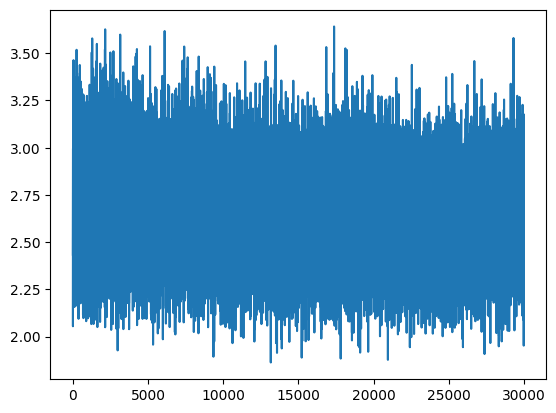

In [40]:
plt.plot(stepi, lossi)

In [41]:

embedding = C[Xtr] 
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss # dev loss


tensor(2.5958, grad_fn=<NllLossBackward0>)

In [42]:

embedding = C[Xdev] 
hidden_layer = torch.tanh(embedding.view(-1,6)) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss # dev loss


tensor(2.5826, grad_fn=<NllLossBackward0>)

A point could reach where batchsize become soo low that there will be lot of noise in the dataset and we could increase the batchsize so that we have a better gradient and we are not thrashing too much and optimise them properly. This could be resolved by reducing lr to 0.05

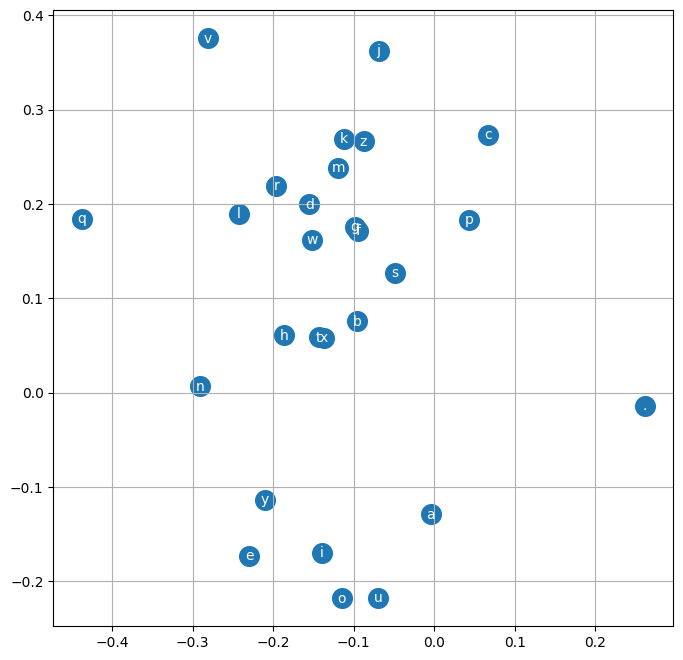

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


Network understood to separate out the similar characters and cluster them separately. a e i o u comes together while q farther way

### Improving the embedding vectors

In [38]:
# initialising
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((80,300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g) 

# taking the same set of parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters) # 10k params

32967

In [39]:
W1.shape[0]

80

In [40]:
lri = []
lossi = []
stepi = []

In [41]:
for i in range(500000):
    
    # minibatch construct
    index = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    embedding = C[Xtr[index]] # index into those rows in the dataset therefore causing the embeedings to be of shape [32,3,2] instead of [228146,3,2]
    hidden_layer = torch.tanh(embedding.view(-1,W1.shape[0])) @ W1 + b1
    logits = hidden_layer @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[index]) # each minibatch for each Y
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    #update
    lr = 0.1 * (0.99 ** (i // 10000))
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # plotting the log loss

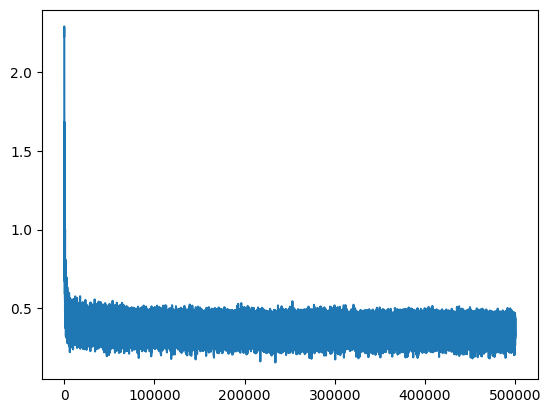

In [42]:
plt.plot(stepi, lossi)

In [43]:

embedding = C[Xtr] 
hidden_layer = torch.tanh(embedding.view(-1,W1.shape[0])) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss # training loss

tensor(2.2905, grad_fn=<NllLossBackward0>)

In [44]:

embedding = C[Xdev] 
hidden_layer = torch.tanh(embedding.view(-1,W1.shape[0])) @ W1 + b1
logits = hidden_layer @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss # dev loss


tensor(2.2975, grad_fn=<NllLossBackward0>)

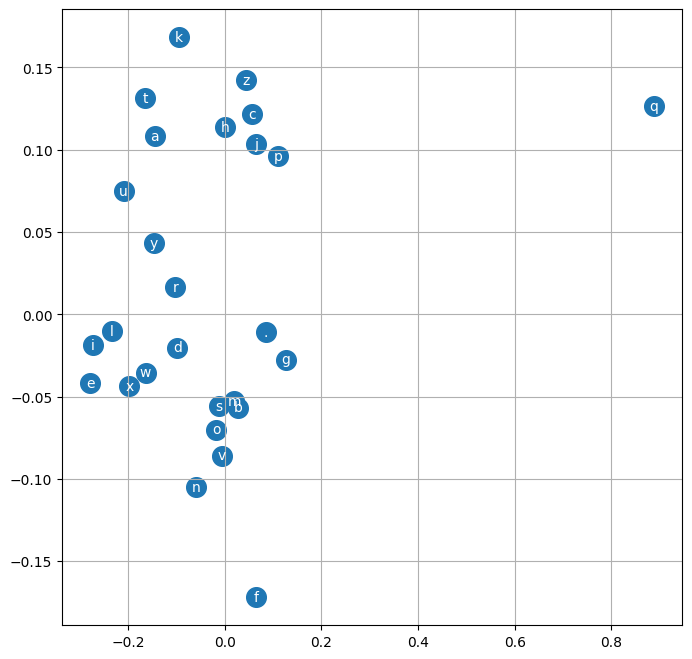

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


To improve we can make use of a few things:

- Change the number of neurons in the hidden layer
- Change the dimensionality of the embedding lookup table
- Change the number of characters we are feeding in, input as in the context to the model
- Change the details of the optimisation, how long we are running it, the learning rate, how does it change over time, how does it decay, change the batch size and therefore get a better convergence speed in terms of how many sec/min we get to train the model and many other methods

In [1]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all zeros
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)    
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


NameError: name 'torch' is not defined

In [47]:
block_size

4